<a href="https://colab.research.google.com/github/KARUNYA-R-P/FACIAL-EMOTION-DETECTION/blob/main/Animal_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F667852%2F1176357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240226%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240226T082245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D22d1668f9f5762eb2d1eb915c767b3763e766087a606a4cabf2c81f383397444a04dfa473270c6d8591f6b18591c28b96777469bfa34edb168402498363b88b3bc4667587fe223ea90329f2bb96083b3f225c4b9b3b4929cd5eea3de3504eb2689aa77fe6b9bd3e1c881bfb556b6a3b71d584d2f90e41d26ad33a794607564b920257ea5bb7f4e0d4a5158df92c2d5f0c786a34a5b4c0b613316c753a760a28ecfc3f90c53a0c1d0dbdfc0d5608de58ea8cc0569ae841ff830a0a6dbcb29397c88742a775137a77d7027dce9bf566cc39198ba7b12ce3e795170a0cf92877859d9c411a4360fb770b2b8cf2affd27e4fa4886428b00e5fe92edca44a3c9a8c1e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 729700755 bytes downloaded
Downloaded and uncompressed: animal-faces
Data source import complete.


**About the dataset**
This dataset, also known as Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512×512 resolution.
There are three domains of classes, each providing about 5000 images. By having multiple (three) domains and diverse images of various breeds per each domain, AFHQ sets a challenging image-to-image translation problem. The classes are:



1.  dog
2.  cat
3.  wildlife



In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
data_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    for filename in filenames:
        data_paths.append(os.path.join(dirname, filename))
print("total number of data:",len(data_paths))

/kaggle/input
/kaggle/input/animal-faces
/kaggle/input/animal-faces/afhq
/kaggle/input/animal-faces/afhq/val
/kaggle/input/animal-faces/afhq/val/cat
/kaggle/input/animal-faces/afhq/val/dog
/kaggle/input/animal-faces/afhq/val/wild
/kaggle/input/animal-faces/afhq/train
/kaggle/input/animal-faces/afhq/train/cat
/kaggle/input/animal-faces/afhq/train/dog
/kaggle/input/animal-faces/afhq/train/wild
total number of data: 16130


**Check to whether train on GPU or CPU**
* if there is gpu, will train on gpu
* else train on cpu

In [5]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(1) # to make sure the result always the same
torch.use_deterministic_algorithms(True) # Needed for reproducible results
device = ""
if torch.cuda.is_available():
    print("has gpu, using gpu")
    device = torch.device("cuda")
else:
    print("only cpu, using cpu")
    device = torch.device("cpu")

has gpu, using gpu


**Load the dataset**
* only load the test set provided, which has 500 dog images, 500 cat images and 500 wildlife
* the images will be resized, and normalized from 0 to 255 => -1 to 1
* the commented out code below is data augmentation, which is not required in this case

In [6]:
image_size = 64
#image_size = 32
# noc = 1
# transform = transforms.Compose(
#     [transforms.Resize((image_size,image_size)), transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
# )
root_path="/kaggle/input/animal-faces/afhq/val/"
noc = 3
transform = transforms.Compose(
    [transforms.Resize((image_size,image_size)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5,))]
)
train_set = torchvision.datasets.ImageFolder(root=root_path,transform=transform)

# augment_transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(p=1),transform]
# )
# augmented_set = torchvision.datasets.ImageFolder(root=root_path,transform=augment_transform)
# train_set = torch.utils.data.ConcatDataset([train_set,augmented_set])

# augment_transform = transforms.Compose(
#     [transforms.GaussianBlur(kernel_size=5),transform]
# )
# augmented_set = torchvision.datasets.ImageFolder(root=root_path,transform=augment_transform)
# train_set = torch.utils.data.ConcatDataset([train_set,augmented_set])


# augment_transform = transforms.Compose(
#     [transforms.RandomRotation(degrees=8),transform]
# )
# augmented_set = torchvision.datasets.ImageFolder(root=root_path,transform=augment_transform)
# train_set = torch.utils.data.ConcatDataset([train_set,augmented_set])

# augment_transform = transforms.Compose(
#     [transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5,), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomAdjustSharpness(3,p=0.5), transform]
# )
# augmented_set = torchvision.datasets.ImageFolder(root=root_path,transform=augment_transform)
# train_set = torch.utils.data.ConcatDataset([train_set,augmented_set])

batch_size = 4

sample_size = len(train_set)//batch_size*batch_size
print(len(train_set))
print(sample_size)
indices = list(range(0, sample_size))
train_set = torch.utils.data.Subset(train_set, indices)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)

transform_denormalize = transforms.Compose(
    [transforms.Normalize((0,0,0), (1/0.5,1/0.5,1/0.5,)),transforms.Normalize((-0.5,-0.5,-0.5,), (1,1,1))]
)

1500
1500


**Sample data**
* some of the data in the dataset are shown below
* label 0 is cat, label 1 is dog, and label 2 is wildlife

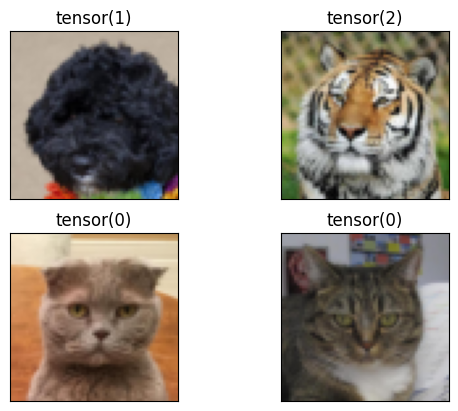

In [7]:
for n, (real_samples, real_label) in enumerate(train_loader):
    for i in range(batch_size):
        ax = plt.subplot(math.ceil(math.sqrt(batch_size)), math.ceil(math.sqrt(batch_size)), i + 1)
        sample = real_samples[i]
        sample = transform_denormalize(sample)
        plt.imshow(sample.squeeze().permute(1,2,0))
        plt.title(real_label[i])
        #plt.imshow(sample.reshape(image_size,image_size,noc),cmap="gray")
        plt.xticks([])
        plt.yticks([])
    break

**Discriminator model**
* the discriminator model consist of convolutional networks
* the purpose of discriminator model is to identify if the image is real (1) or generated (0)
* the purpose of relu activation layer will activate when the input is more non-negative
* the purpose of dropout layer is to prevent overfitting
* the sigmoid layer will return a value from 0(generated image) to 1(real image)

In [8]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(noc, image_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(image_size*8, 1, kernel_size=4),
            nn.Sigmoid(),
        )

    def forward(self, x):
        #print("input shape:",x.shape)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)
print("output shape:",discriminator(train_set[0][0].to(device=device)).shape)

output shape: torch.Size([1, 1, 1])


**Generator model**
* the generator model will takes a noise input and generated a desired image
* the noise input will go through transposed convolution layer to generate a image
* the tanh layer will return values of -1 to 1, this is desired as our image was normalized into that range

In [9]:
generator_input_size = 50
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(generator_input_size, image_size*8, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(image_size, noc, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        #print("input shape:",x.shape)
        output = self.model(x)
        return output

generator = Generator().to(device=device)
#latent_space_samples = torch.randn((generator_input_size, 1, 1)).to(device=device)
latent_space_samples = torch.randn((1,generator_input_size, 1, 1)).to(device=device)
print("output shape:",generator(latent_space_samples).shape)

output shape: torch.Size([1, 3, 64, 64])


**Train the models**
* the generator will generate images that can deceive the discriminator
* the discriminator will become better at identifying real/generated image

In [10]:
lr = 0.0001
num_epochs = 300
loss_function = nn.BCELoss()

import time

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

start = time.time()
for epoch in range(num_epochs+1):
  for n, (real_samples, _) in enumerate(train_loader):
    # Data for training the discriminator
    real_samples = real_samples.to(device=device)
    real_samples_labels = torch.ones((batch_size, 1)).to(device=device) # 1 indicates real data

    latent_space_samples = torch.randn((batch_size, generator_input_size, 1, 1)).to(device=device)
    generated_samples = generator(latent_space_samples)

    generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device) #0 indicates fake data
    all_samples = torch.cat((real_samples, generated_samples))
    all_samples_labels = torch.cat(
        (real_samples_labels, generated_samples_labels)
    )

    # Training the discriminator
    discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    output_discriminator = output_discriminator.view(output_discriminator.size()[:2])
    loss_discriminator = loss_function(
        output_discriminator, all_samples_labels
    )
    loss_discriminator.backward()
    optimizer_discriminator.step()

    # Data for training the generator
    latent_space_samples = torch.randn((batch_size, generator_input_size, 1, 1)).to(device=device)

    # Training the generator
    generator.zero_grad()
    generated_samples = generator(latent_space_samples)
    output_discriminator_generated = discriminator(generated_samples)
    output_discriminator_generated = output_discriminator_generated.view(output_discriminator_generated.size()[:2])
    loss_generator = loss_function(
        output_discriminator_generated, real_samples_labels
    )
    loss_generator.backward()
    optimizer_generator.step()


  # Show loss
  if (epoch%5==0):
    print("time taken for 5 epoch: {}s".format(time.time()-start))
    start = time.time()
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

time taken for 5 epoch: 8.870326042175293s
Epoch: 0 Loss D.: 0.12353944033384323
Epoch: 0 Loss G.: 5.26224946975708
time taken for 5 epoch: 38.41847538948059s
Epoch: 5 Loss D.: 0.002838903572410345
Epoch: 5 Loss G.: 6.352078437805176
time taken for 5 epoch: 38.158344745635986s
Epoch: 10 Loss D.: 0.2622443437576294
Epoch: 10 Loss G.: 4.784726142883301
time taken for 5 epoch: 38.14769268035889s
Epoch: 15 Loss D.: 0.06398532539606094
Epoch: 15 Loss G.: 4.276540756225586
time taken for 5 epoch: 38.06075596809387s
Epoch: 20 Loss D.: 0.32082903385162354
Epoch: 20 Loss G.: 3.727795124053955
time taken for 5 epoch: 37.909552574157715s
Epoch: 25 Loss D.: 0.13990439474582672
Epoch: 25 Loss G.: 2.7702503204345703
time taken for 5 epoch: 37.45057439804077s
Epoch: 30 Loss D.: 0.06374435871839523
Epoch: 30 Loss G.: 3.5898706912994385
time taken for 5 epoch: 37.5889892578125s
Epoch: 35 Loss D.: 0.06896981596946716
Epoch: 35 Loss G.: 5.102977752685547
time taken for 5 epoch: 38.02595114707947s
Epoch: 

**Check the model**
* Check the model output to see if the model generates deseired image

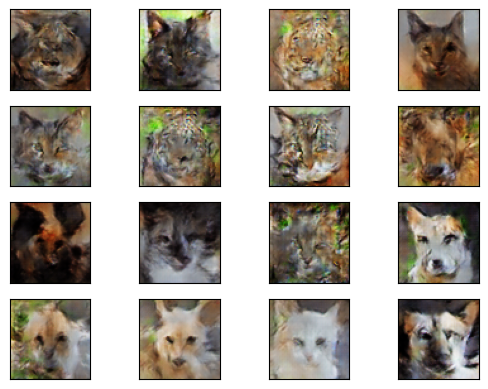

In [11]:
generate_image_num = 16
latent_space_samples = torch.randn(generate_image_num, generator_input_size,1,1).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
for i in range(generate_image_num):
  ax = plt.subplot(math.ceil(math.sqrt(generate_image_num)), math.ceil(math.sqrt(generate_image_num)), i + 1)
  generated_sample = transform_denormalize(generated_samples[i])
  plt.imshow(generated_sample.squeeze().permute(1,2,0))
  #plt.imshow(generated_samples[i].reshape(image_size,image_size,noc),cmap="gray")
  plt.xticks([])
  plt.yticks([])


**Save model**
* The state_dict() model requires the original class definition
* The model does not require the original calss definition

In [12]:
torch.save(generator.state_dict(), "animalImageGAN.pt")

In [13]:
torch.save(generator, "animalImageGAN_full.pt")